#### This notebook contains all the deep learning experiments for melody extraction from polyphonic audio.

In [3]:
## if you already have these packages, dont run this block
!pip install llvmlite==0.31.0
import llvmlite
!pip install librosa
!pip install soundfile

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile

In [5]:
import importlib
moduleName = input('Enter name:') ## LibFMP without ''
importlib.import_module(moduleName)

Enter name:LibFMP


<module 'LibFMP' (namespace)>

In [0]:
from LibFMP.C8.S2_Salience import compute_salience_rep as salience
## to compute salience representation 

In [0]:
def return_stft_and_salience(filename):
    x,sr = librosa.load(filename, mono=False)
    mix = x[0,:]+x[1,:]
    X = librosa.stft(mix)
    X_left = librosa.stft(np.asfortranarray(x[0,:]))
    X_right = librosa.stft(np.asfortranarray(x[1,:]))
    Z, F_coef_hertz, F_coef_cents = salience(mix,sr,N=2048, H=512, R=10, gamma=0, F_min=8.175799, F_max=1760)
    
    ## in salience() I used N=2048=window, H=512=hop, same as librosa.stft()
    ## also in salience() I used R=10 = resolution of y-axis in cents
    ## salience() fixes F_min as 0 cents => 8.175799 hz = 0 cents so F_max = 1760 hz = 9300 cents
    ## resolution = 10 cents => F_coef_cents will be [0,10,20,30,....,9300] => shape = (931,) 
    ## F_coef_hertz[] will be just the cents-to-hz conversion of F_coef_cents[]
    
    return X, X_left, X_right, Z, F_coef_hertz, F_coef_cents

In [8]:
X, X_left, X_right, Z, F_coef_hertz, F_coef_cents = return_stft_and_salience(
                                                    'mir1k_16wavfiles/abjones_1_01.wav')

print(X.shape) ## stft, shape = (freq bins, timesteps)
print(Z.shape) ## salience, shape = (cents, timesteps)
print(F_coef_cents.shape) ## must be (931,)
print(F_coef_hertz.shape) ## must be (931,)

(1025, 501)
(931, 501)
(931,)
(931,)


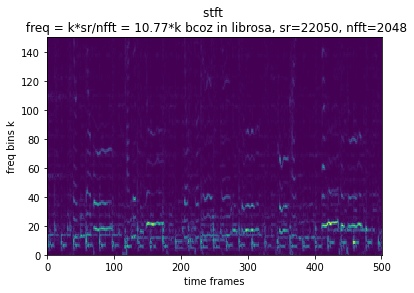

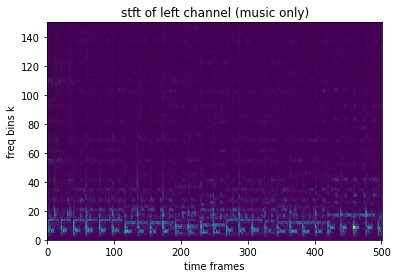

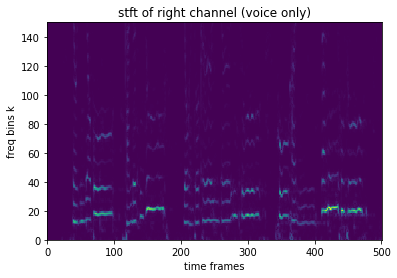

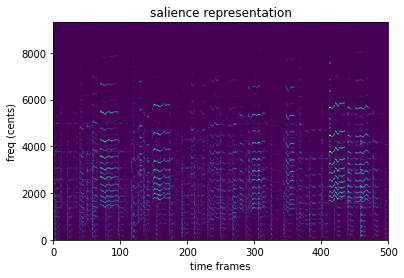

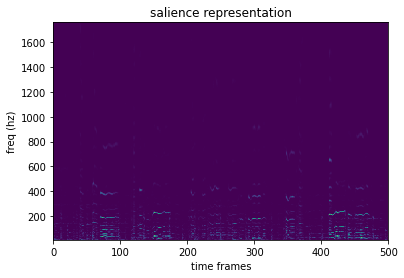

In [9]:
## plots for mir1k_16wavfiles/abjones_1_01.wav

## stft
plt.pcolormesh(np.abs(X))
plt.ylim([0,150])
plt.ylabel('freq bins k')
plt.xlabel('time frames')
plt.title('stft \n freq = k*sr/nfft = 10.77*k bcoz in librosa, sr=22050, nfft=2048')
plt.show()

## stft of left channel (music only)
plt.pcolormesh(np.abs(X_left))
plt.ylim([0,150])
plt.ylabel('freq bins k')
plt.xlabel('time frames')
plt.title('stft of left channel (music only)')
plt.show()

## stft of right channel (voice only)
plt.pcolormesh(np.abs(X_right))
plt.ylim([0,150])
plt.ylabel('freq bins k')
plt.xlabel('time frames')
plt.title('stft of right channel (voice only)')
plt.show()

## salience representation
time_frames = Z.shape[1] ## 501
t = np.arange(time_frames)
plt.pcolormesh(t,F_coef_cents,Z)
plt.ylabel('freq (cents)')
plt.xlabel('time frames')
plt.title('salience representation')
plt.show()
plt.pcolormesh(t,F_coef_hertz,Z)
plt.ylabel('freq (hz)')
plt.xlabel('time frames')
plt.title('salience representation')
plt.show()

In [0]:
def return_salience_and_melody(wavfile, annotationfile):
    x,sr = librosa.load(wavfile, mono=False)
    mix = x[0,:]+x[1,:]
    Z, F_coef_hertz, F_coef_cents = salience(mix,sr,N=882, H=441, R=10, gamma=0, F_min=8.175799, F_max=1760)
    ## N=882=window, H=441=hop, same as MIR1K specifications  
    
    L = np.loadtxt(annotationfile) 
    ## annotation F0 values in semitone (with 8.175799 = 0 semitone = 0 cents)
    anno = L*100   ## convert annotation from semitone to cents
    anno = anno/10 ## in Z, freq resolution = 10 cents not 1 cents, so same here
    
    ## though Z is computed as per MIR1K standards (N=882, H=441) still it may have extra timesteps
    Z_salience = Z[:,0:len(anno)] ## choose the 1st L timesteps where L = len(anno)
    
    return Z_salience, anno

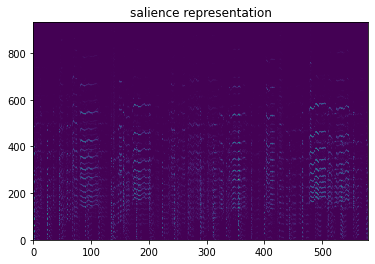

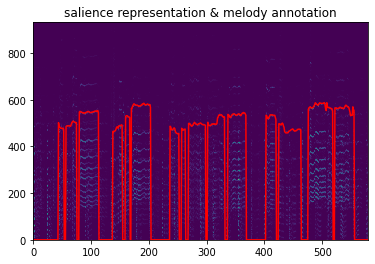

In [11]:
## let us plot salience representation and melody annotation together

Z, anno = return_salience_and_melody('mir1k_16wavfiles/abjones_1_01.wav',
                                     'mir1k_16labels/abjones_1_01.pv')
plt.pcolormesh(Z)
plt.title('salience representation')
plt.show()
plt.pcolormesh(Z)
plt.plot(anno,'r')
plt.title('salience representation & melody annotation')
plt.show()

In [0]:
## obtain salience representation & annotation (12 audios to be used for training)
## total 16 files in the polyphonic dataset
## may take 3-4 mins to run

Z1, anno1 = return_salience_and_melody('mir1k_16wavfiles/abjones_1_01.wav', 'mir1k_16labels/abjones_1_01.pv')
Z2, anno2 = return_salience_and_melody('mir1k_16wavfiles/abjones_1_02.wav', 'mir1k_16labels/abjones_1_02.pv')
Z3, anno3 = return_salience_and_melody('mir1k_16wavfiles/abjones_1_03.wav', 'mir1k_16labels/abjones_1_03.pv')
Z4, anno4 = return_salience_and_melody('mir1k_16wavfiles/abjones_1_04.wav', 'mir1k_16labels/abjones_1_04.pv')
Z5, anno5 = return_salience_and_melody('mir1k_16wavfiles/abjones_2_01.wav', 'mir1k_16labels/abjones_2_01.pv')
Z6, anno6 = return_salience_and_melody('mir1k_16wavfiles/abjones_2_02.wav', 'mir1k_16labels/abjones_2_02.pv')
Z7, anno7 = return_salience_and_melody('mir1k_16wavfiles/abjones_2_03.wav', 'mir1k_16labels/abjones_2_03.pv')
Z8, anno8 = return_salience_and_melody('mir1k_16wavfiles/abjones_2_04.wav', 'mir1k_16labels/abjones_2_04.pv')
Z9, anno9 = return_salience_and_melody('mir1k_16wavfiles/abjones_2_05.wav', 'mir1k_16labels/abjones_2_05.pv')
Z10, anno10 = return_salience_and_melody('mir1k_16wavfiles/abjones_2_08.wav', 'mir1k_16labels/abjones_2_08.pv')
Z11, anno11 = return_salience_and_melody('mir1k_16wavfiles/abjones_2_10.wav', 'mir1k_16labels/abjones_2_10.pv')
Z12, anno12 = return_salience_and_melody('mir1k_16wavfiles/abjones_2_12.wav', 'mir1k_16labels/abjones_2_12.pv')


In [0]:
## each audio will have different no. of timesteps depending on their duration
## for training model, we will use chunks of 200 timesteps (~= 4 sec)
## N = window = 882 samples, H = hop = 441 samples, sampling rate = 22050 samples/sec
## hence 200 timesteps ~= 4 sec

In [0]:
## divide training files into chunks of 200 timesteps
## suppose an audio has 580 timesteps then produce 3 chunks [0,199], [200,399], [380,579]
## since [400,599] not possible

## total 12 audios for training, each audio will give 2-3 chunks
## so we can expect total 25-35 chunks

def prepare_dataset(Z, anno):
    X = []
    t = []
    chunk_size = 200
    timesteps = len(anno)
    chunks = int(1+np.floor((timesteps-1)/chunk_size))
    for i in range(chunks-1):
        X.append(Z[:,(chunk_size*i):(chunk_size*(i+1))])
        t.append(anno[(chunk_size*i):(chunk_size*(i+1))])
    X.append(Z[:,(timesteps-chunk_size):(timesteps)])
    t.append(anno[(timesteps-chunk_size):(timesteps)])
    
    return X,t

In [0]:
X1, t1 = prepare_dataset(Z1, anno1)
X2, t2 = prepare_dataset(Z2, anno2)
X3, t3 = prepare_dataset(Z3, anno3)
X4, t4 = prepare_dataset(Z4, anno4)
X5, t5 = prepare_dataset(Z5, anno5)
X6, t6 = prepare_dataset(Z6, anno6)
X7, t7 = prepare_dataset(Z7, anno7)
X8, t8 = prepare_dataset(Z8, anno8)
X9, t9 = prepare_dataset(Z9, anno9)
X10, t10 = prepare_dataset(Z10, anno10)
X11, t11 = prepare_dataset(Z11, anno11)
X12, t12 = prepare_dataset(Z12, anno12)

In [0]:
X_train = []
X_train.extend(X1) ## not append as X1 already a list
X_train.extend(X2)
X_train.extend(X3)
X_train.extend(X4)
X_train.extend(X5)
X_train.extend(X6)
X_train.extend(X7)
X_train.extend(X8)
X_train.extend(X9)
X_train.extend(X10)
X_train.extend(X11)
X_train.extend(X12)

X_train = np.array(X_train)

In [0]:
t_train = []
t_train.extend(t1) ## not append as t1 already a list
t_train.extend(t2)
t_train.extend(t3)
t_train.extend(t4)
t_train.extend(t5)
t_train.extend(t6)
t_train.extend(t7)
t_train.extend(t8)
t_train.extend(t9)
t_train.extend(t10)
t_train.extend(t11)
t_train.extend(t12)

t_train = np.array(t_train)

In [18]:
print(X_train.shape)
print(t_train.shape)

(28, 931, 200)
(28, 200)


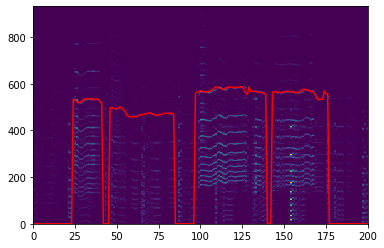

In [19]:
index = np.random.randint(0,28) ## a random no. in [0,28)
plt.pcolormesh(X_train[index]) ## X_train[i] = (931,200)
plt.plot(t_train[index],'r')   ## t_train[i] = (200,)
plt.show() 
## plotting salience and annotation for a single chunk

In [0]:
## we get total 28 chunks
## above plot is just one chunk randomly chosen out of total 28 chunks
## from above plot we see that chosen chunk has exactly 200 timesteps

## X_train has 28 matrices each = (931,200)
## t_train has 28 sequences each = (200,)
## next we create a seq2seq model where i/p = (931,200) & o/p = (200,)
## clearly timesteps = 200, features = 931, samples = 28

In [21]:
samples = X_train.shape[0] ## 28
new_timesteps = X_train.shape[2] ## 200
features = X_train.shape[1] ## 931

## for giving i/p to RNN models, the correct shape is (samples,timesteps,features)
## in this case, X_train should have shape (28,200,931) 
## but currently X_train = (28,931,200) so we have to rearrange X_train
X_train_reshaped = np.empty((X_train.shape[0], X_train.shape[2], X_train.shape[1])) ## (28,200,931)
for i in range(X_train.shape[0]):
    X_train_reshaped[i] = X_train[i].T

## now t_train has shape (28,200). each of the 28 sequences of t_train has shape (200,)
## these sequences are real-valued but for classification we need fixed class labels
## so we need to quantize all 28 sequences of t_train by rounding elements to nearest integers
## there will be some quantization error (suppose 858.6 rounds to 859 => error 0.4)
## (resolution = 10 cents => error = 4 cents. similarly we can say that max quantization error = 5 cents)
## In RPA computation, default tolerance = 50 cents so it can handle quantization error
t_train_quantized = np.round(t_train)

## after model processes X_train it predicts probabilities for each timestep not the class label directly
## to compare that with actual labels, each sequence of t_train_quantized must be one-hot encoded
from keras.utils import to_categorical ## for one-hot encoding
t_train_1hot = []
for i in range(samples):
    t_train_1hot.append(to_categorical(t_train_quantized[i], num_classes=features))
t_train_1hot = np.array(t_train_1hot)


Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense

In [23]:
## building an LSTM model

model = Sequential()
model.add(LSTM(units=1000, input_shape=(new_timesteps, features), return_sequences=True))
## return_sequences=True so that at each timestep, neuron gives an o/p
model.add(TimeDistributed(Dense(units=features, activation='softmax')))
## TimeDistributed because at each timestep we need probabilities so each timestep needs a Dense layer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_reshaped, t_train_1hot, epochs=120)
## training will take ~= 30 mins

Epoch 1/120
28/28 [==============================] - 10s 357ms/step - loss: 7.0857 - accuracy: 7.1429e-04
Epoch 2/120
28/28 [==============================] - 9s 331ms/step - loss: 4.7882 - accuracy: 0.4055
Epoch 3/120
28/28 [==============================] - 9s 334ms/step - loss: 4.2136 - accuracy: 0.4055
Epoch 4/120
28/28 [==============================] - 9s 332ms/step - loss: 3.9741 - accuracy: 0.4055
Epoch 5/120
28/28 [==============================] - 9s 330ms/step - loss: 3.5628 - accuracy: 0.4055
Epoch 6/120
28/28 [==============================] - 9s 328ms/step - loss: 3.3071 - accuracy: 0.4059
Epoch 7/120
28/28 [==============================] - 10s 344ms/step - loss: 3.1125 - accuracy: 0.4089
Epoch 8/120
28/28 [==============================] - 9s 328ms/step - loss: 2.9074 - accuracy: 0.4148
Epoch 9/120
28/28 [==============================] - 9s 332ms/step - loss: 2.7238 - accuracy: 0.4261
Epoch 10/120
28/28 [==============================] - 9s 336ms/step - loss: 2.5796 - 

In [24]:
## next we define a function that calculates RPA for an audio using the above trained model

!pip install mir_eval
from mir_eval.melody import raw_pitch_accuracy

     |████████████████████████████████| 92kB 3.4MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-cp36-none-any.whl size=96515 sha256=f0c08803a488fa9afe3ac2e69863a1e03367d511780355aaf5bc76a14f645b7e
  Stored in directory: /root/.cache/pip/wheels/49/ce/30/730fa72addf275e49d90683b01b3613048b4be3bf7ff8eb6ec
Successfully built mir-eval


In [0]:
def return_RPA(wavfile, annotationfile, model):
    Z, anno = return_salience_and_melody(wavfile, annotationfile)
    ## next convert Z into chunks. each chunk should have 200 timesteps. model trained that way
    ## if Z has 580 timesteps then convert it to 600 timesteps by zero padding
    ## then we can get 3 chunks out of Z
    chunk_size = 200
    timesteps = len(anno)
    chunks = int(1+np.floor((timesteps-1)/chunk_size))
    Z_padded = np.zeros((Z.shape[0],chunks*chunk_size))
    Z_padded[:,0:timesteps] = Z
    
    X=[] ## this will store the chunks
    for i in range(chunks):
        X.append(Z_padded[:,(chunk_size*i):(chunk_size*(i+1))])
    X = np.array(X)
    
    ## suppose we get 3 chunks then X will have shape (3,931,200) 
    ## 931 comes from return_salience_and_melody(), where F_min = 8.175799 hz, F_max = 1760 hz
    ## and resolution = 10 cents so F_min = 0 cents (by default), F_max = 9300 cents
    ## and frequency bins = [0,10,20,30,....,9300] = 931 bins
    ## but for i/p to RNN, required shape = (samples,timesteps,features) = (3,200,931)
    ## so reshape X
    
    X_reshaped=[]
    for i in range(chunks):
        X_reshaped.append(X[i].T)
    X_reshaped = np.array(X_reshaped)
    
    y_pred = model.predict(X_reshaped) ## the softmax probabilities
    y_labels=[]
    for i in range(chunks):
        ## y_pred[i] will be o/p for ith chunk 
        ## 200 timesteps, each timestep can belong to one of 931 classes => 931 probabilities
        ## so y_pred[i] looks like (200,931). to get class labels we use np.argmax
        y_labels.append(np.argmax(y_pred[i], axis=1))
    y_labels = np.array(y_labels)
    
    ## now y_labels[i] contains class labels for ith chunk
    ## 200 timesteps => 200 labels => y_labels[i] = (200,)
    ## suppose audio had 580 timesteps => gives 3 chunks => y_labels = (3,200)
    ## convert y_labels into single array of length 600 then consider 1st 580 timesteps for RPA
    
    melody_pred = np.empty(chunks*chunk_size)
    for i in range(chunks):
        melody_pred[(chunk_size*i):(chunk_size*(i+1))] = y_labels[i]
    
    melody_pred_aligned = np.empty(timesteps)
    melody_pred_aligned = melody_pred[0:timesteps]
    
    ## finally RPA calculation 
    voice_anno = np.empty(len(anno))
    for i in range(len(anno)):
        if(anno[i]==0):
            voice_anno[i] = False
        else:
            voice_anno[i] = True
        
    voice_traj = np.empty(len(melody_pred_aligned))
    for i in range(len(melody_pred_aligned)):
        if(melody_pred_aligned[i]==0):
            voice_traj[i] = True
        else:
            voice_traj[i] = False
    
    annotation = anno*10 
    prediction = melody_pred_aligned*10 
    ## back to normal resolution
    
    RPA = raw_pitch_accuracy(voice_anno, annotation, voice_traj, prediction)
    return annotation, prediction, RPA

RPA = 77.09 percent


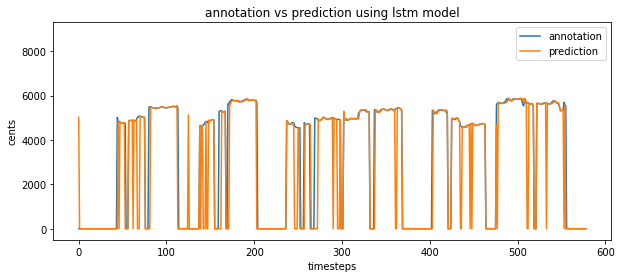

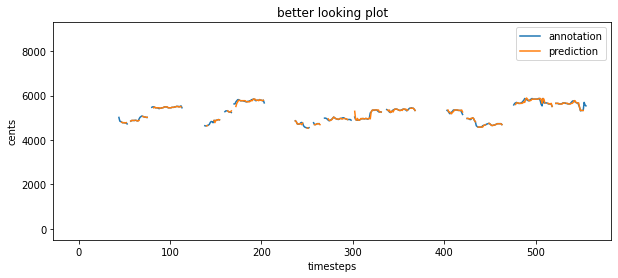

In [26]:
## results for mir1k_16wavfiles/abjones_1_01.wav
## this audio was used for training so its a familiar audio for the model
annotation, prediction, RPA = return_RPA('mir1k_16wavfiles/abjones_1_01.wav', 
                                         'mir1k_16labels/abjones_1_01.pv', model)
print('RPA = %.2f percent' %(RPA*100))
plt.figure(figsize=(10,4))
plt.plot(annotation, label='annotation')
plt.plot(prediction, label='prediction')
plt.legend()
plt.ylim([-500,9300])
plt.title('annotation vs prediction using lstm model')
plt.ylabel('cents')
plt.xlabel('timesteps')
plt.show()

for i in range(len(annotation)):
    if(annotation[i]==0):
        annotation[i]=np.NaN
    if(prediction[i]==0):
        prediction[i]=np.NaN

plt.figure(figsize=(10,4))
plt.plot(annotation, label='annotation')
plt.plot(prediction, label='prediction')
plt.legend()
plt.ylim([-500,9300])
plt.title('better looking plot')
plt.ylabel('cents')
plt.xlabel('timesteps')
plt.show()

RPA = 65.84 percent


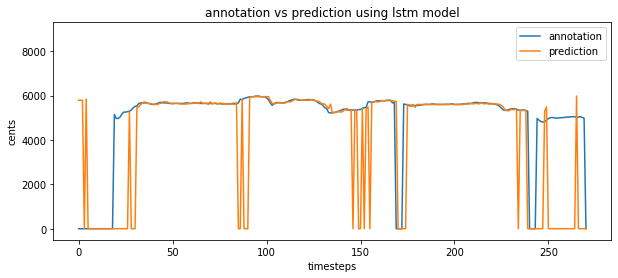

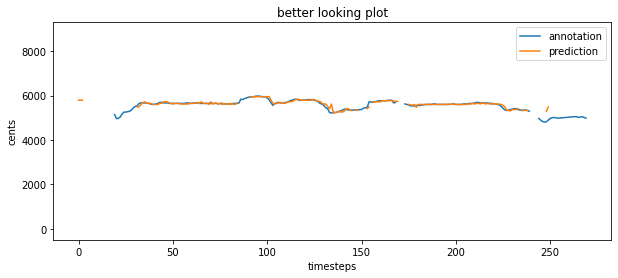

In [27]:
## results for mir1k_16wavfiles/abjones_2_11.wav
## this is an unknown audio for model as this audio was not used for training 
annotation, prediction, RPA = return_RPA('mir1k_16wavfiles/abjones_2_11.wav', 
                                         'mir1k_16labels/abjones_2_11.pv', model)
print('RPA = %.2f percent' %(RPA*100))
plt.figure(figsize=(10,4))
plt.plot(annotation, label='annotation')
plt.plot(prediction, label='prediction')
plt.legend()
plt.ylim([-500,9300])
plt.title('annotation vs prediction using lstm model')
plt.ylabel('cents')
plt.xlabel('timesteps')
plt.show()

for i in range(len(annotation)):
    if(annotation[i]==0):
        annotation[i]=np.NaN
    if(prediction[i]==0):
        prediction[i]=np.NaN

plt.figure(figsize=(10,4))
plt.plot(annotation, label='annotation')
plt.plot(prediction, label='prediction')
plt.legend()
plt.ylim([-500,9300])
plt.title('better looking plot')
plt.ylabel('cents')
plt.xlabel('timesteps')
plt.show()

In [41]:
## next we build another model, "bi-directional lstm"

from keras.layers import Bidirectional
model2 = Sequential()
model2.add(Bidirectional(LSTM(units=1000, input_shape=(new_timesteps, features), return_sequences=True)))
## return_sequences=True so that at each timestep, neuron gives an o/p
model2.add(TimeDistributed(Dense(units=features, activation='softmax')))
## TimeDistributed because at each timestep we need probabilities so each timestep needs a Dense layer
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train_reshaped, t_train_1hot, epochs=120)
## training will take ~= 30 mins
## SAME NO. OF EPOCHS AS IN LSTM MODEL

Epoch 1/120
28/28 [==============================] - 19s 673ms/step - loss: 7.0855 - accuracy: 0.0011
Epoch 2/120
28/28 [==============================] - 18s 658ms/step - loss: 4.3875 - accuracy: 0.4055
Epoch 3/120
28/28 [==============================] - 18s 639ms/step - loss: 3.6246 - accuracy: 0.4055
Epoch 4/120
28/28 [==============================] - 22s 780ms/step - loss: 3.2162 - accuracy: 0.4295
Epoch 5/120
28/28 [==============================] - 18s 649ms/step - loss: 2.8011 - accuracy: 0.4541
Epoch 6/120
28/28 [==============================] - 18s 648ms/step - loss: 2.5012 - accuracy: 0.4655
Epoch 7/120
28/28 [==============================] - 18s 651ms/step - loss: 2.3165 - accuracy: 0.4805
Epoch 8/120
28/28 [==============================] - 18s 651ms/step - loss: 2.1759 - accuracy: 0.4980
Epoch 9/120
28/28 [==============================] - 18s 650ms/step - loss: 2.0832 - accuracy: 0.5154
Epoch 10/120
28/28 [==============================] - 18s 656ms/step - loss: 2.012

RPA = 96.23 percent


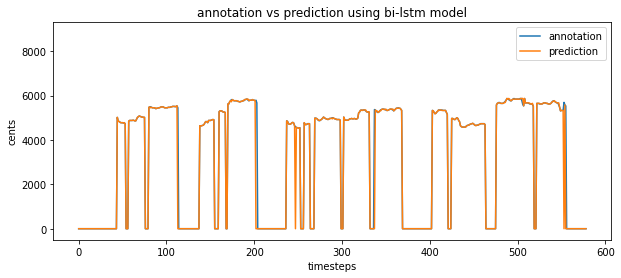

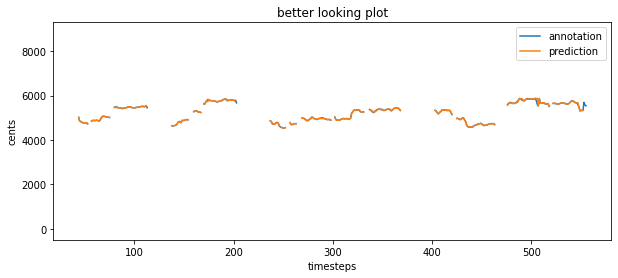

In [42]:
## bilstm results for mir1k_16wavfiles/abjones_1_01.wav
## this audio was used for training so its a familiar audio for the model
annotation, prediction, RPA = return_RPA('mir1k_16wavfiles/abjones_1_01.wav', 
                                         'mir1k_16labels/abjones_1_01.pv', model2)
print('RPA = %.2f percent' %(RPA*100))
plt.figure(figsize=(10,4))
plt.plot(annotation, label='annotation')
plt.plot(prediction, label='prediction')
plt.legend()
plt.ylim([-500,9300])
plt.title('annotation vs prediction using bi-lstm model')
plt.ylabel('cents')
plt.xlabel('timesteps')
plt.show()

for i in range(len(annotation)):
    if(annotation[i]==0):
        annotation[i]=np.NaN
    if(prediction[i]==0):
        prediction[i]=np.NaN

plt.figure(figsize=(10,4))
plt.plot(annotation, label='annotation')
plt.plot(prediction, label='prediction')
plt.legend()
plt.ylim([-500,9300])
plt.title('better looking plot')
plt.ylabel('cents')
plt.xlabel('timesteps')
plt.show()

In [0]:
## bi-lstm gives far better performance than lstm
## bi-lstm model gives RPA = 96.23 % for mir1k_16wavfiles/abjones_1_01.wav 
## lstm model gave RPA = 77.09 % for the same file

## This audio file was used in training both lstm & bi-lstm model
## Let us see how bi-lstm model performs on unseen audio

RPA = 72.02 percent


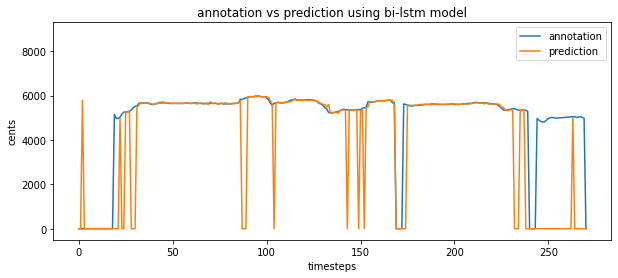

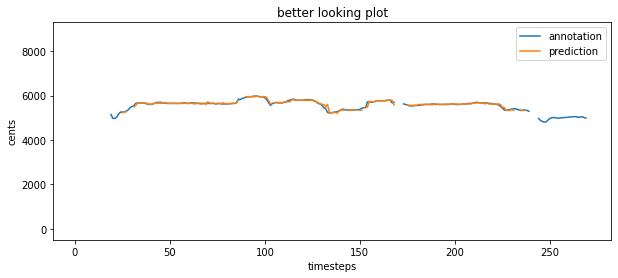

In [43]:
## results for mir1k_16wavfiles/abjones_2_11.wav
## this is an unknown audio for model as this audio was not used for training 
annotation, prediction, RPA = return_RPA('mir1k_16wavfiles/abjones_2_11.wav', 
                                         'mir1k_16labels/abjones_2_11.pv', model2)
print('RPA = %.2f percent' %(RPA*100))
plt.figure(figsize=(10,4))
plt.plot(annotation, label='annotation')
plt.plot(prediction, label='prediction')
plt.legend()
plt.ylim([-500,9300])
plt.title('annotation vs prediction using bi-lstm model')
plt.ylabel('cents')
plt.xlabel('timesteps')
plt.show()

for i in range(len(annotation)):
    if(annotation[i]==0):
        annotation[i]=np.NaN
    if(prediction[i]==0):
        prediction[i]=np.NaN

plt.figure(figsize=(10,4))
plt.plot(annotation, label='annotation')
plt.plot(prediction, label='prediction')
plt.legend()
plt.ylim([-500,9300]) 
plt.title('better looking plot')
plt.ylabel('cents')
plt.xlabel('timesteps')
plt.show()

In [0]:
## even for unseen audio, bilstm model performs better than lstm model
## unseen audio = mir1k_16wavfiles/abjones_2_11.wav, neither lstm nor bilstm model used it for training
## for this audio, bilstm model gives RPA = 72.02 %, lstm model gives RPA = 65.84 %
## also for the same audio, using F0_tracking() of LibFMP library gave RPA = 44.86 %

In [47]:
## next we build another model, "deep bi-directional lstm with 2 layers"

model3 = Sequential()
model3.add(Bidirectional(LSTM(units=1000, input_shape=(new_timesteps, features), return_sequences=True)))
## return_sequences=True so that at each timestep, neuron gives an o/p
model3.add(Bidirectional(LSTM(units=1000, return_sequences=True)))
## 2nd layer of bi-lstm, again neuron gives o/p at each timestep
model3.add(TimeDistributed(Dense(units=features, activation='softmax')))
## TimeDistributed because at each timestep we need probabilities so each timestep needs a Dense layer
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(X_train_reshaped, t_train_1hot, epochs=80) 
## LESSER NO. OF EPOCHS THAN LSTM & BI-LSTM MODEL IN ORDER TO AVOID OVERFITTING
## training will take ~= 60 mins

Epoch 1/80
28/28 [==============================] - 49s 2s/step - loss: 6.8650 - accuracy: 1.7857e-04
Epoch 2/80
28/28 [==============================] - 51s 2s/step - loss: 5.9543 - accuracy: 0.4055
Epoch 3/80
28/28 [==============================] - 48s 2s/step - loss: 5.5641 - accuracy: 0.3661
Epoch 4/80
28/28 [==============================] - 47s 2s/step - loss: 4.4043 - accuracy: 0.4643
Epoch 5/80
28/28 [==============================] - 46s 2s/step - loss: 3.1815 - accuracy: 0.4721
Epoch 6/80
28/28 [==============================] - 47s 2s/step - loss: 2.8401 - accuracy: 0.4409
Epoch 7/80
28/28 [==============================] - 48s 2s/step - loss: 2.4708 - accuracy: 0.4730
Epoch 8/80
28/28 [==============================] - 47s 2s/step - loss: 2.3773 - accuracy: 0.5009
Epoch 9/80
28/28 [==============================] - 46s 2s/step - loss: 2.1466 - accuracy: 0.5277
Epoch 10/80
28/28 [==============================] - 47s 2s/step - loss: 1.9928 - accuracy: 0.5186
Epoch 11/80
28/

RPA = 100.00 percent


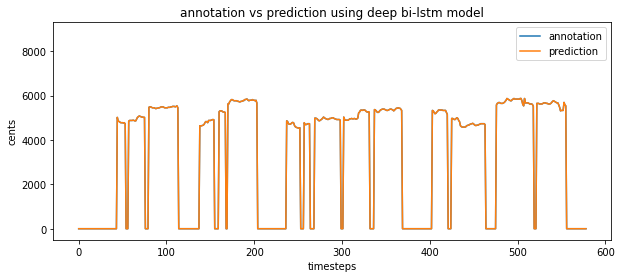

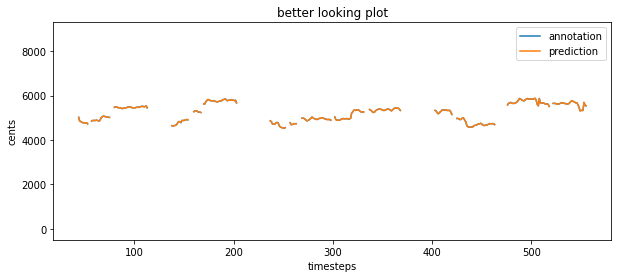

In [48]:
## deep bilstm results for mir1k_16wavfiles/abjones_1_01.wav
## this audio was used for training so its a familiar audio for the model
annotation, prediction, RPA = return_RPA('mir1k_16wavfiles/abjones_1_01.wav', 
                                         'mir1k_16labels/abjones_1_01.pv', model3)
print('RPA = %.2f percent' %(RPA*100))
plt.figure(figsize=(10,4))
plt.plot(annotation, label='annotation')
plt.plot(prediction, label='prediction')
plt.legend()
plt.ylim([-500,9300])
plt.title('annotation vs prediction using deep bi-lstm model')
plt.ylabel('cents')
plt.xlabel('timesteps')
plt.show()

for i in range(len(annotation)):
    if(annotation[i]==0):
        annotation[i]=np.NaN
    if(prediction[i]==0):
        prediction[i]=np.NaN

plt.figure(figsize=(10,4))
plt.plot(annotation, label='annotation')
plt.plot(prediction, label='prediction')
plt.legend()
plt.ylim([-500,9300])
plt.title('better looking plot')
plt.ylabel('cents')
plt.xlabel('timesteps')
plt.show()

RPA = 77.37 percent


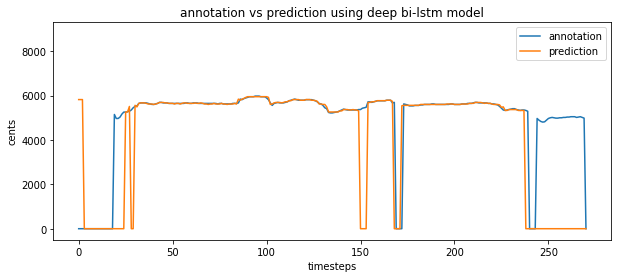

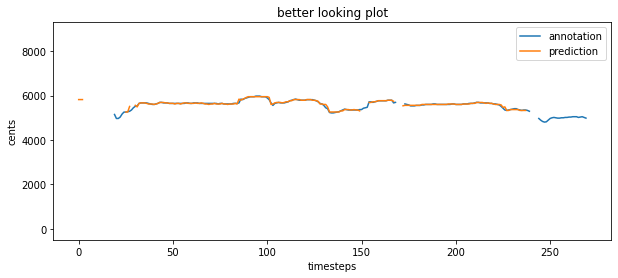

In [49]:
## results for mir1k_16wavfiles/abjones_2_11.wav
## this is an unknown audio for model as this audio was not used for training 
annotation, prediction, RPA = return_RPA('mir1k_16wavfiles/abjones_2_11.wav', 
                                         'mir1k_16labels/abjones_2_11.pv', model3)
print('RPA = %.2f percent' %(RPA*100))
plt.figure(figsize=(10,4))
plt.plot(annotation, label='annotation')
plt.plot(prediction, label='prediction')
plt.legend()
plt.ylim([-500,9300])
plt.title('annotation vs prediction using deep bi-lstm model')
plt.ylabel('cents')
plt.xlabel('timesteps')
plt.show()

for i in range(len(annotation)):
    if(annotation[i]==0):
        annotation[i]=np.NaN
    if(prediction[i]==0):
        prediction[i]=np.NaN

plt.figure(figsize=(10,4))
plt.plot(annotation, label='annotation')
plt.plot(prediction, label='prediction')
plt.legend()
plt.ylim([-500,9300]) 
plt.title('better looking plot')
plt.ylabel('cents')
plt.xlabel('timesteps')
plt.show()

In [1]:
## for unknown audio, deep bilstm outperforms both lstm and bilstm
## deep bilstm model achieves 77.37 % RPA on an unknown audio 'mir1k_16wavfiles/abjones_2_11.wav'
## this audio was not used in training
## this is better than 72.02 % RPA of bilstm model & 65.84 % RPA of lstm model

In [51]:
## lets calculate mean RPA for all audios used in training
## first we will use lstm model for calculating mean RPA, then we will use bi-lstm model then deep bi-lstm model
## this will give a better comparison between lstm, bilstm and deep bilstm model

## lstm
annotation_01, prediction_01, RPA_01 = return_RPA('mir1k_16wavfiles/abjones_1_01.wav', 'mir1k_16labels/abjones_1_01.pv', model)
annotation_02, prediction_02, RPA_02 = return_RPA('mir1k_16wavfiles/abjones_1_02.wav', 'mir1k_16labels/abjones_1_02.pv', model)
annotation_03, prediction_03, RPA_03 = return_RPA('mir1k_16wavfiles/abjones_1_03.wav', 'mir1k_16labels/abjones_1_03.pv', model)
annotation_04, prediction_04, RPA_04 = return_RPA('mir1k_16wavfiles/abjones_1_04.wav', 'mir1k_16labels/abjones_1_04.pv', model)
annotation_05, prediction_05, RPA_05 = return_RPA('mir1k_16wavfiles/abjones_2_01.wav', 'mir1k_16labels/abjones_2_01.pv', model)
annotation_06, prediction_06, RPA_06 = return_RPA('mir1k_16wavfiles/abjones_2_02.wav', 'mir1k_16labels/abjones_2_02.pv', model)
annotation_07, prediction_07, RPA_07 = return_RPA('mir1k_16wavfiles/abjones_2_03.wav', 'mir1k_16labels/abjones_2_03.pv', model)
annotation_08, prediction_08, RPA_08 = return_RPA('mir1k_16wavfiles/abjones_2_04.wav', 'mir1k_16labels/abjones_2_04.pv', model)
annotation_09, prediction_09, RPA_09 = return_RPA('mir1k_16wavfiles/abjones_2_05.wav', 'mir1k_16labels/abjones_2_05.pv', model)
annotation_10, prediction_10, RPA_10 = return_RPA('mir1k_16wavfiles/abjones_2_08.wav', 'mir1k_16labels/abjones_2_08.pv', model)
annotation_11, prediction_11, RPA_11 = return_RPA('mir1k_16wavfiles/abjones_2_10.wav', 'mir1k_16labels/abjones_2_10.pv', model)
annotation_12, prediction_12, RPA_12 = return_RPA('mir1k_16wavfiles/abjones_2_12.wav', 'mir1k_16labels/abjones_2_12.pv', model)

mean_RPA_lstm = np.mean(np.array([RPA_01, RPA_02, RPA_03, RPA_04, RPA_05, RPA_06, RPA_07, RPA_08, RPA_09, RPA_10, RPA_11, RPA_12]))
std_dev_RPA_lstm = np.std(np.array([RPA_01, RPA_02, RPA_03, RPA_04, RPA_05, RPA_06, RPA_07, RPA_08, RPA_09, RPA_10, RPA_11, RPA_12]))

## bi-lstm
annotation_01, prediction_01, RPA_01 = return_RPA('mir1k_16wavfiles/abjones_1_01.wav', 'mir1k_16labels/abjones_1_01.pv', model2) ## model2 => bilstm
annotation_02, prediction_02, RPA_02 = return_RPA('mir1k_16wavfiles/abjones_1_02.wav', 'mir1k_16labels/abjones_1_02.pv', model2)
annotation_03, prediction_03, RPA_03 = return_RPA('mir1k_16wavfiles/abjones_1_03.wav', 'mir1k_16labels/abjones_1_03.pv', model2)
annotation_04, prediction_04, RPA_04 = return_RPA('mir1k_16wavfiles/abjones_1_04.wav', 'mir1k_16labels/abjones_1_04.pv', model2)
annotation_05, prediction_05, RPA_05 = return_RPA('mir1k_16wavfiles/abjones_2_01.wav', 'mir1k_16labels/abjones_2_01.pv', model2)
annotation_06, prediction_06, RPA_06 = return_RPA('mir1k_16wavfiles/abjones_2_02.wav', 'mir1k_16labels/abjones_2_02.pv', model2)
annotation_07, prediction_07, RPA_07 = return_RPA('mir1k_16wavfiles/abjones_2_03.wav', 'mir1k_16labels/abjones_2_03.pv', model2)
annotation_08, prediction_08, RPA_08 = return_RPA('mir1k_16wavfiles/abjones_2_04.wav', 'mir1k_16labels/abjones_2_04.pv', model2)
annotation_09, prediction_09, RPA_09 = return_RPA('mir1k_16wavfiles/abjones_2_05.wav', 'mir1k_16labels/abjones_2_05.pv', model2)
annotation_10, prediction_10, RPA_10 = return_RPA('mir1k_16wavfiles/abjones_2_08.wav', 'mir1k_16labels/abjones_2_08.pv', model2)
annotation_11, prediction_11, RPA_11 = return_RPA('mir1k_16wavfiles/abjones_2_10.wav', 'mir1k_16labels/abjones_2_10.pv', model2)
annotation_12, prediction_12, RPA_12 = return_RPA('mir1k_16wavfiles/abjones_2_12.wav', 'mir1k_16labels/abjones_2_12.pv', model2)

mean_RPA_bilstm = np.mean(np.array([RPA_01, RPA_02, RPA_03, RPA_04, RPA_05, RPA_06, RPA_07, RPA_08, RPA_09, RPA_10, RPA_11, RPA_12]))
std_dev_RPA_bilstm = np.std(np.array([RPA_01, RPA_02, RPA_03, RPA_04, RPA_05, RPA_06, RPA_07, RPA_08, RPA_09, RPA_10, RPA_11, RPA_12]))

## deep bi-lstm (2 layers)
annotation_01, prediction_01, RPA_01 = return_RPA('mir1k_16wavfiles/abjones_1_01.wav', 'mir1k_16labels/abjones_1_01.pv', model3) ## model3 => deep bilstm
annotation_02, prediction_02, RPA_02 = return_RPA('mir1k_16wavfiles/abjones_1_02.wav', 'mir1k_16labels/abjones_1_02.pv', model3)
annotation_03, prediction_03, RPA_03 = return_RPA('mir1k_16wavfiles/abjones_1_03.wav', 'mir1k_16labels/abjones_1_03.pv', model3)
annotation_04, prediction_04, RPA_04 = return_RPA('mir1k_16wavfiles/abjones_1_04.wav', 'mir1k_16labels/abjones_1_04.pv', model3)
annotation_05, prediction_05, RPA_05 = return_RPA('mir1k_16wavfiles/abjones_2_01.wav', 'mir1k_16labels/abjones_2_01.pv', model3)
annotation_06, prediction_06, RPA_06 = return_RPA('mir1k_16wavfiles/abjones_2_02.wav', 'mir1k_16labels/abjones_2_02.pv', model3)
annotation_07, prediction_07, RPA_07 = return_RPA('mir1k_16wavfiles/abjones_2_03.wav', 'mir1k_16labels/abjones_2_03.pv', model3)
annotation_08, prediction_08, RPA_08 = return_RPA('mir1k_16wavfiles/abjones_2_04.wav', 'mir1k_16labels/abjones_2_04.pv', model3)
annotation_09, prediction_09, RPA_09 = return_RPA('mir1k_16wavfiles/abjones_2_05.wav', 'mir1k_16labels/abjones_2_05.pv', model3)
annotation_10, prediction_10, RPA_10 = return_RPA('mir1k_16wavfiles/abjones_2_08.wav', 'mir1k_16labels/abjones_2_08.pv', model3)
annotation_11, prediction_11, RPA_11 = return_RPA('mir1k_16wavfiles/abjones_2_10.wav', 'mir1k_16labels/abjones_2_10.pv', model3)
annotation_12, prediction_12, RPA_12 = return_RPA('mir1k_16wavfiles/abjones_2_12.wav', 'mir1k_16labels/abjones_2_12.pv', model3)

mean_RPA_deep_bilstm = np.mean(np.array([RPA_01, RPA_02, RPA_03, RPA_04, RPA_05, RPA_06, RPA_07, RPA_08, RPA_09, RPA_10, RPA_11, RPA_12]))
std_dev_RPA_deep_bilstm = np.std(np.array([RPA_01, RPA_02, RPA_03, RPA_04, RPA_05, RPA_06, RPA_07, RPA_08, RPA_09, RPA_10, RPA_11, RPA_12]))

print('using lstm : mean RPA of all audios used for training = %.2f percent' %(mean_RPA_lstm * 100))
print('standard deviation = %.2f percent' %(std_dev_RPA_lstm * 100))
print('using bi-lstm : mean RPA of all audios used for training = %.2f percent' %(mean_RPA_bilstm * 100))
print('standard deviation = %.2f percent' %(std_dev_RPA_bilstm * 100))
print('using deep bi-lstm : mean RPA of all audios used for training = %.2f percent' %(mean_RPA_deep_bilstm * 100))
print('standard deviation = %.2f percent' %(std_dev_RPA_deep_bilstm * 100))


using lstm : mean RPA of all audios used for training = 81.30 percent
standard deviation = 3.24 percent
using bi-lstm : mean RPA of all audios used for training = 95.81 percent
standard deviation = 2.13 percent
using deep bi-lstm : mean RPA of all audios used for training = 99.96 percent
standard deviation = 0.14 percent


In [52]:
## lets calculate mean RPA for all audios NOT used in training 
## excluding 'mir1k_16wavfiles/abjones_2_07.wav' as it gave bad results when F0_tracking() was used for RPA
## first we will use lstm model for calculating mean RPA, then we will use bilstm model then deep bilstm

## lstm
annotation_01, prediction_01, RPA_01 = return_RPA('mir1k_16wavfiles/abjones_2_06.wav', 'mir1k_16labels/abjones_2_06.pv', model)
annotation_02, prediction_02, RPA_02 = return_RPA('mir1k_16wavfiles/abjones_2_09.wav', 'mir1k_16labels/abjones_2_09.pv', model)
annotation_03, prediction_03, RPA_03 = return_RPA('mir1k_16wavfiles/abjones_2_11.wav', 'mir1k_16labels/abjones_2_11.pv', model)

mean_RPA_lstm = np.mean(np.array([RPA_01, RPA_02, RPA_03]))
std_dev_RPA_lstm = np.std(np.array([RPA_01, RPA_02, RPA_03]))

## bi-lstm
annotation_01, prediction_01, RPA_01 = return_RPA('mir1k_16wavfiles/abjones_2_06.wav', 'mir1k_16labels/abjones_2_06.pv', model2) ## model2 => bilstm
annotation_02, prediction_02, RPA_02 = return_RPA('mir1k_16wavfiles/abjones_2_09.wav', 'mir1k_16labels/abjones_2_09.pv', model2)
annotation_03, prediction_03, RPA_03 = return_RPA('mir1k_16wavfiles/abjones_2_11.wav', 'mir1k_16labels/abjones_2_11.pv', model2)

mean_RPA_bilstm = np.mean(np.array([RPA_01, RPA_02, RPA_03]))
std_dev_RPA_bilstm = np.std(np.array([RPA_01, RPA_02, RPA_03]))

## deep bi-lstm
annotation_01, prediction_01, RPA_01 = return_RPA('mir1k_16wavfiles/abjones_2_06.wav', 'mir1k_16labels/abjones_2_06.pv', model3) ## model3 => deep bilstm
annotation_02, prediction_02, RPA_02 = return_RPA('mir1k_16wavfiles/abjones_2_09.wav', 'mir1k_16labels/abjones_2_09.pv', model3)
annotation_03, prediction_03, RPA_03 = return_RPA('mir1k_16wavfiles/abjones_2_11.wav', 'mir1k_16labels/abjones_2_11.pv', model3)

mean_RPA_deep_bilstm = np.mean(np.array([RPA_01, RPA_02, RPA_03]))
std_dev_RPA_deep_bilstm = np.std(np.array([RPA_01, RPA_02, RPA_03]))

print('using lstm : mean RPA of audios NOT used for training = %.2f percent' %(mean_RPA_lstm * 100))
print('standard deviation = %.2f percent' %(std_dev_RPA_lstm * 100))
print('using bi-lstm : mean RPA of audios NOT used for training = %.2f percent' %(mean_RPA_bilstm * 100))
print('standard deviation = %.2f percent' %(std_dev_RPA_bilstm * 100))
print('using deep bi-lstm : mean RPA of audios NOT used for training = %.2f percent' %(mean_RPA_deep_bilstm * 100))
print('standard deviation = %.2f percent' %(std_dev_RPA_deep_bilstm * 100))


using lstm : mean RPA of audios NOT used for training = 56.25 percent
standard deviation = 7.01 percent
using bi-lstm : mean RPA of audios NOT used for training = 63.00 percent
standard deviation = 6.59 percent
using deep bi-lstm : mean RPA of audios NOT used for training = 73.21 percent
standard deviation = 4.76 percent


In [0]:
## deep bilstm model clearly outperforms the lstm and bilstm model in case of both used audios and unknown audios
## lets save the trained bilstm model so that it can be directly used in future without training again

import pickle
pickle.dump(model3, open('deep_bilstm_model.sav', 'wb'))
## model3 => deep bi-lstm 